In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
import pandas as pd

# Utils

In [2]:
def draw_bipartite(filename):
    """ Generate a bipartite graph. Assumes file lines like: user1 movie1 // user2 movie2 // ..."""

    G = nx.Graph()

    with open(filename) as f:
        for line in f:
            user, movie = line.strip().split()
            G.add_node(user, bipartite=0)   # users set
            G.add_node(movie, bipartite=1)  # movies set
            G.add_edge(user, movie)

    # Separate nodes by bipartite sets
    users = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    movies = set(G) - users

    # Get bipartite layout (pass the node set of one bipartite group)
    pos = bipartite_layout(G, users)

    # Draw graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos,
            with_labels=True,
            node_color=["lightblue" if n in users else "orange" for n in G.nodes()],
            node_size=500,
            font_size=8,
            edge_color='gray')

    plt.title("User-Movie Bipartite Graph")
    plt.show()

# (Não usado neste notebook)
def sum_of_bipartite_edge_weights(graph, b1, b2):
    """
    Calculates the weight between two businesses (b1, b2) in the projected graph
    by summing the original 'weight' attributes of edges connecting their common users.

    The weight for each common user is the average of the 'weight' from user->b1 and user->b2.
    """
    projected_weight = 0
    common_users = set(graph.neighbors(b1)) & set(graph.neighbors(b2))

    if not common_users:
        return 0 # No shared users, no edge

    for user in common_users:
        # Get the weight from user to b1 and user to b2 from the original bipartite graph
        weight_b1 = graph[user][b1].get('weight', 0)
        weight_b2 = graph[user][b2].get('weight', 0)

        # Here you define how to combine the weights for each common user.
        # Examples:
        # 1. Sum of their individual weights for this user:
        #    projected_weight += weight_b1 + weight_b2
        # 2. Average of their individual weights for this user:
        #    projected_weight += (weight_b1 + weight_b2) / 2
        # 3. Product (if weights represent 'strength' that can multiply):
        #    projected_weight += weight_b1 * weight_b2
        # 4. Minimum (if you want the 'weakest link' of the shared connection):
        #    projected_weight += min(weight_b1, weight_b2)
        # 5. Maximum (if you want the 'strongest link'):
        #    projected_weight += max(weight_b1, weight_b2)
        # 6. For this example, let's stick with the "sum of averages" from previous:
        projected_weight += (weight_b1 + weight_b2) / 2

    return projected_weight



In [7]:
G = nx.Graph()

with open("yelp_data/rec-yelp-user-business.edges") as f:
    for line in f:
        parts = line.strip().split()
        u, i = parts[0], parts[1]
        G.add_edge(u, i)

len(G)

50395

# Business - Business projection

In [42]:
# For computacional reasons we ignore the weight

#Load the edge list
file_path = 'yelp_data/rec-yelp-user-business.edges'
edges_df = pd.read_csv(file_path, sep='\s+', header=None, names=['user', 'business', 'weight'])

# Create bipartite graph
B = nx.Graph()
for row in edges_df.itertuples(index=False):
    B.add_node(row.user, bipartite=0)
    B.add_node(row.business, bipartite=1)
    B.add_edge(row.user, row.business)  # Ignore weights here for speed

# Extract the two node sets
users = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
businesses = set(B) - users

# Project onto business nodes WITHOUT weights
G_business_unweighted = bipartite.projected_graph(B, businesses)

# Now G_business_unweighted is the unweighted business-business graph
print(f"Number of nodes in unweighted business projection: {G_business_unweighted.number_of_nodes()}")
print(f"Number of edges in unweighted business projection: {G_business_unweighted.number_of_edges()}")

Number of nodes in unweighted business projection: 49523
Number of edges in unweighted business projection: 11965278


# Sampling

For that we selected a random fraction of the network and then the largest component of that network for filter isolated nodes.

In [70]:
import random

def sample_nodes(G, fraction=0.1):
    nodes = list(G.nodes())  # convert NodeView to list
    num_to_sample = int(fraction * G.number_of_nodes())
    sampled_nodes = random.sample(nodes, num_to_sample)
    return G.subgraph(sampled_nodes).copy()

def largest_component(G):
    components = nx.connected_components(G)
    largest = max(components, key=len)
    return G.subgraph(largest).copy()

# For different results change fraction value !!
H = sample_nodes(G_business_unweighted, fraction=0.003)
L = largest_component(H)

print(f"Size of the random samples: {len(H)}")
print(f"Size of the largest component: {len(L)}")

Size of the random samples: 148
Size of the largest component: 53


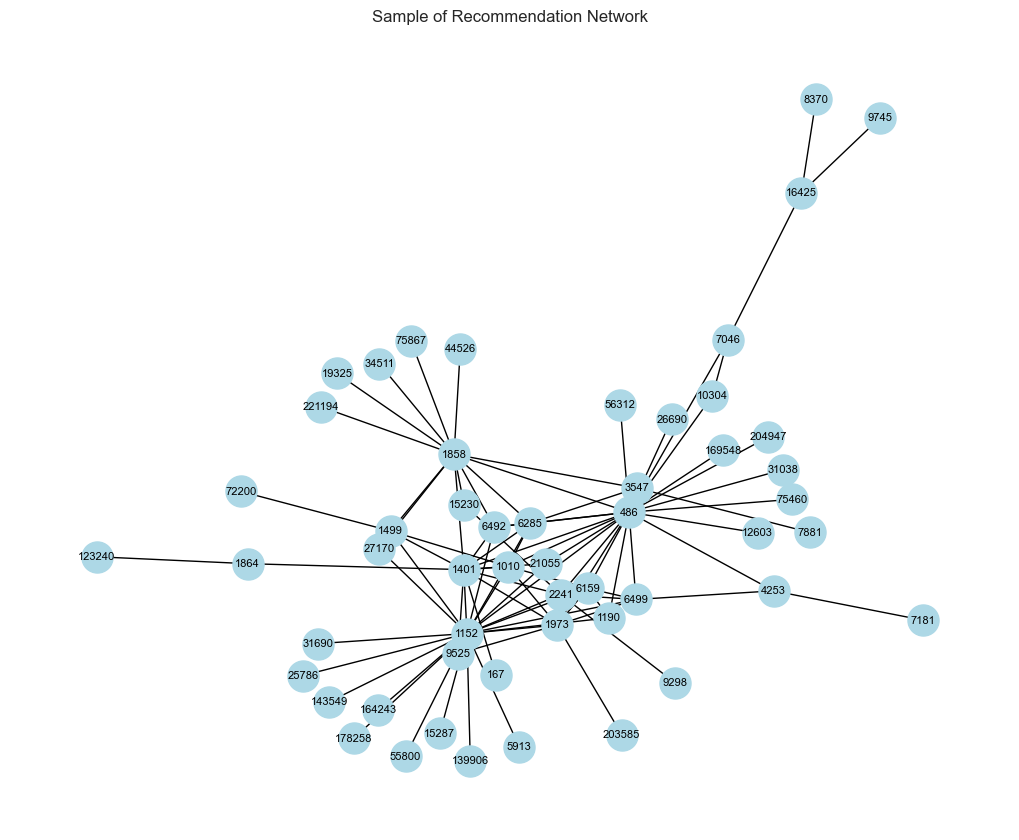

In [71]:
# Plot largest component

plt.figure(figsize=(10, 8))
nx.draw(L, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
plt.title("Sample of Recommendation Network")
plt.show()

In [72]:
# write to a file than relabel:

nx.write_edgelist(L, "yelp_data/yelp_01.txt", data=False)

def relabel_nodes(input_file, output_file):
    """This fucntion renames the nodes to a lower number. Usefull when working with subsample graphs"""

    node_map = {}
    next_id = 0
    edges = []

    with open(input_file) as f:
        for line in f:
            u, v = line.strip().split()
            if u not in node_map:
                node_map[u] = str(next_id)
                next_id += 1
            if v not in node_map:
                node_map[v] = str(next_id)
                next_id += 1
            edges.append((node_map[u], node_map[v]))

    with open(output_file, "w") as f:
        for u, v in edges:
            f.write(f"{u} {v}\n")

    print(f"Relabeled {len(edges)} edges with {len(node_map)} nodes.")
    return output_file

relabel_nodes("yelp_data/yelp_01.txt", "yelp_data/yelp_01_relabeled.txt")

Relabeled 91 edges with 53 nodes.


'yelp_data/yelp_01_relabeled.txt'

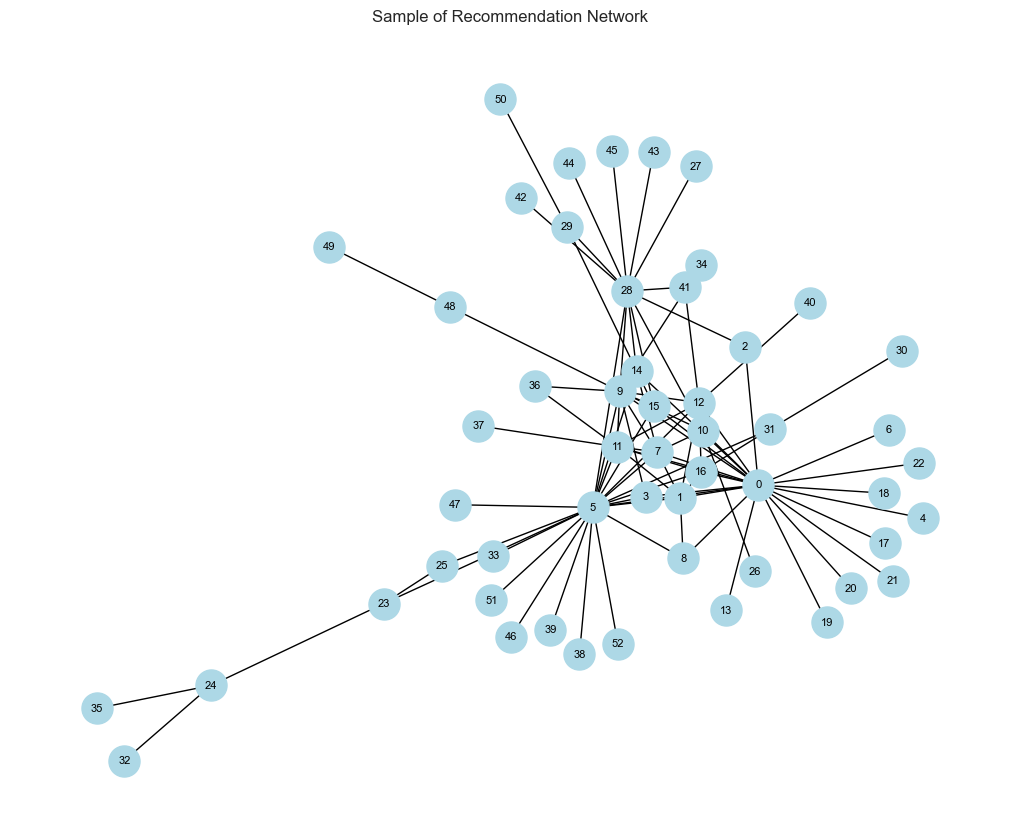

In [73]:
# Plot again

G = nx.Graph()

with open("yelp_data/yelp_01_relabeled.txt") as f:
    for line in f:
        parts = line.strip().split()
        u, i = parts[0], parts[1]
        G.add_edge(u, i)

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
plt.title("Sample of Recommendation Network")
plt.show()

# Community discovery

In [74]:
import community  # python-louvain package

# Run Louvain algorithm with weights and a resolution parameter
partition = community.best_partition(G, weight='weight', resolution=10)

# Add community assignment as node attribute
nx.set_node_attributes(G, partition, 'community')

# Print detected communities for first 10 nodes
print("Detected communities for some nodes:")
for node, comm_id in list(partition.items())[:10]:
    print(f"Node {node}: Community {comm_id}")

# Number of detected communities
num_communities = max(partition.values()) + 1 if partition else 0
print(f"\nNumber of communities detected: {num_communities}")

# Calculate modularity score of the partition
modularity = community.modularity(partition, G, weight='weight')
print(f"Modularity score: {modularity:.3f}")

Detected communities for some nodes:
Node 0: Community 0
Node 1: Community 1
Node 2: Community 2
Node 3: Community 3
Node 4: Community 4
Node 5: Community 5
Node 6: Community 6
Node 7: Community 7
Node 8: Community 8
Node 9: Community 34

Number of communities detected: 36
Modularity score: 0.123


C:\Users\1\AppData\Local\Temp\ipykernel_26484\1440830969.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


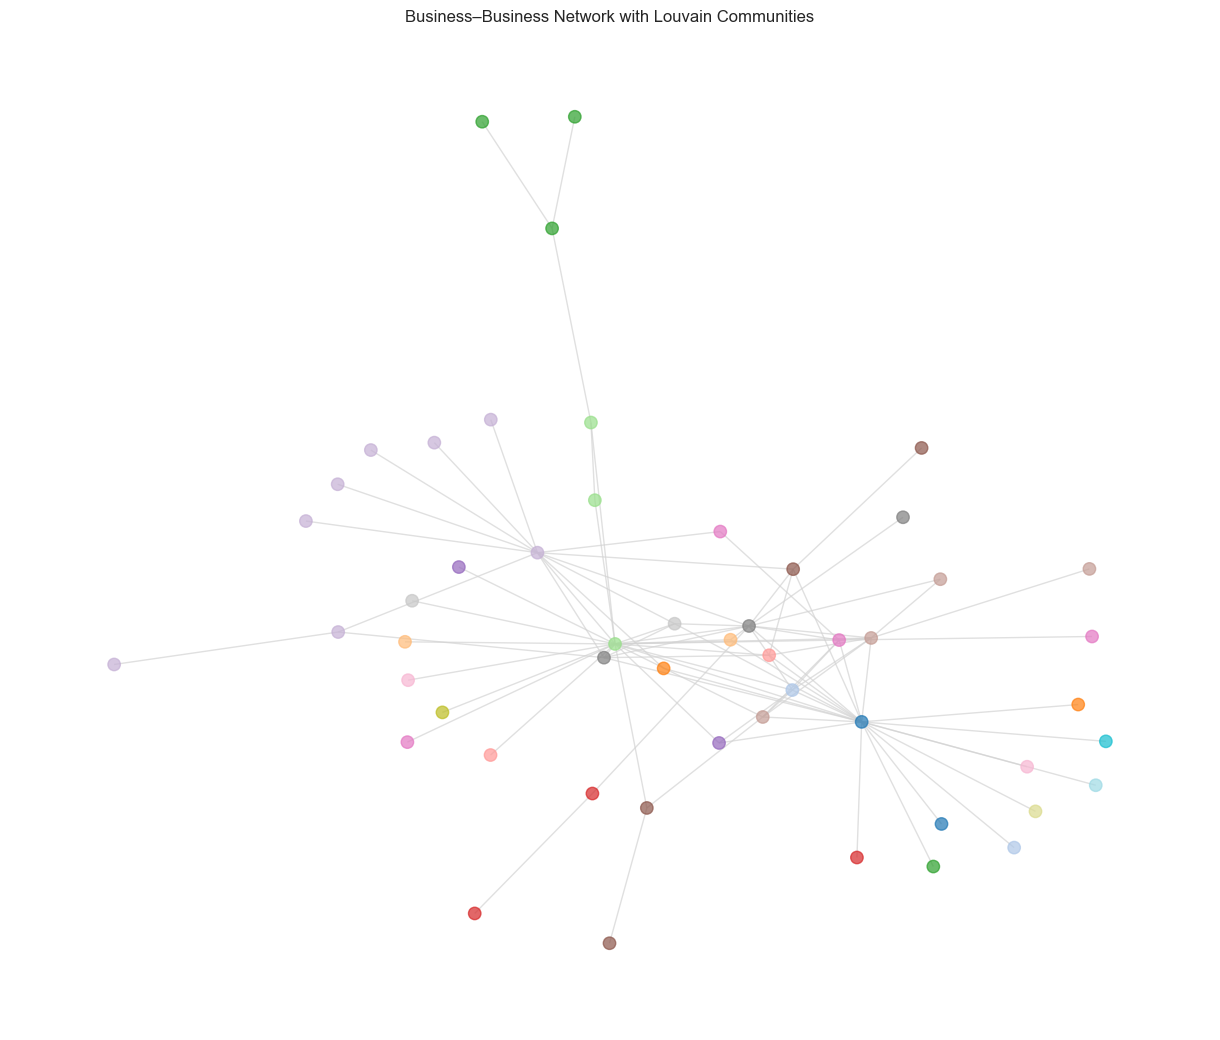

In [75]:
# Assign colors based on community
unique_comms = set(partition.values())
color_map = {c: plt.cm.tab20(i % 20) for i, c in enumerate(unique_comms)}
node_colors = [color_map[partition[n]] for n in G.nodes()]

# Use spring layout
pos = nx.spring_layout(G, k=0.1)

plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    node_color=node_colors,
    node_size=80,
    edge_color='lightgray',
    with_labels=False,
    alpha=0.7
)
plt.title("Business–Business Network with Louvain Communities")
plt.axis("off")
plt.tight_layout()
plt.show()